Running simulation for Ideal Mixture...


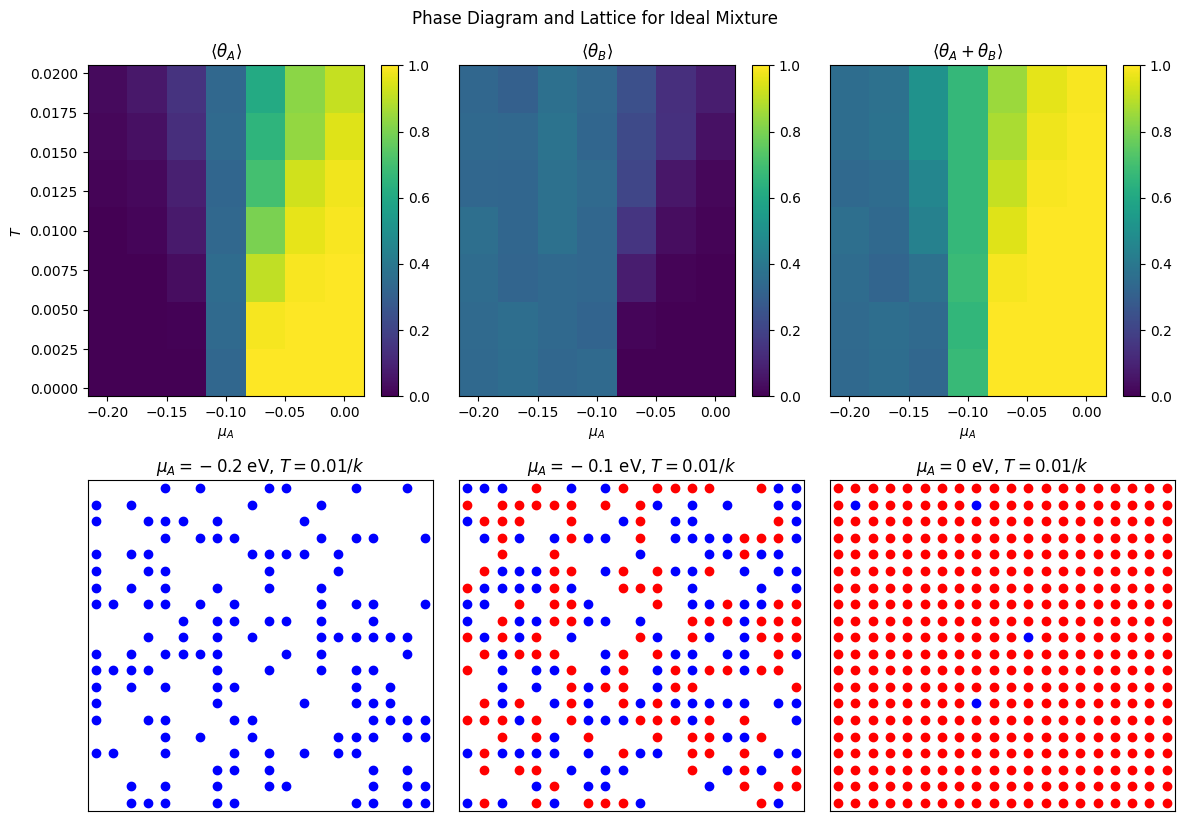

Running simulation for Repulsive Interactions...


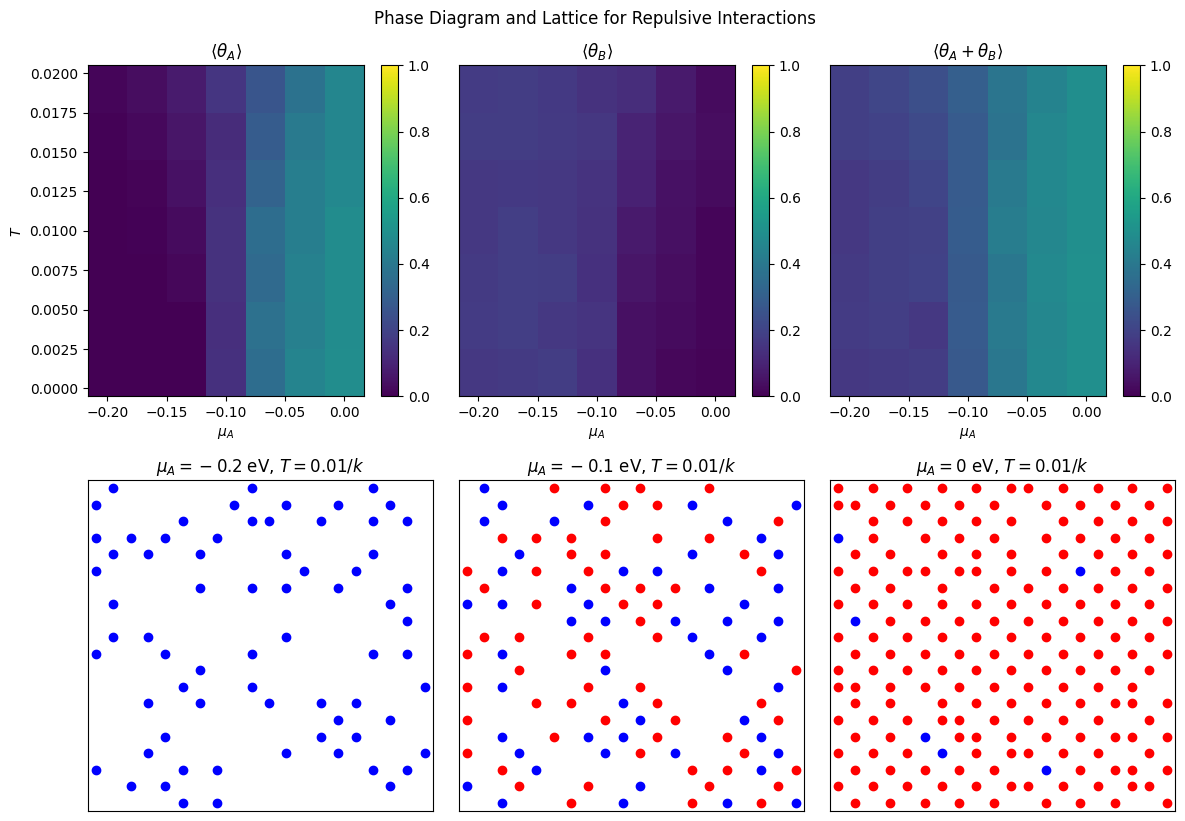

Running simulation for Attractive Interactions...


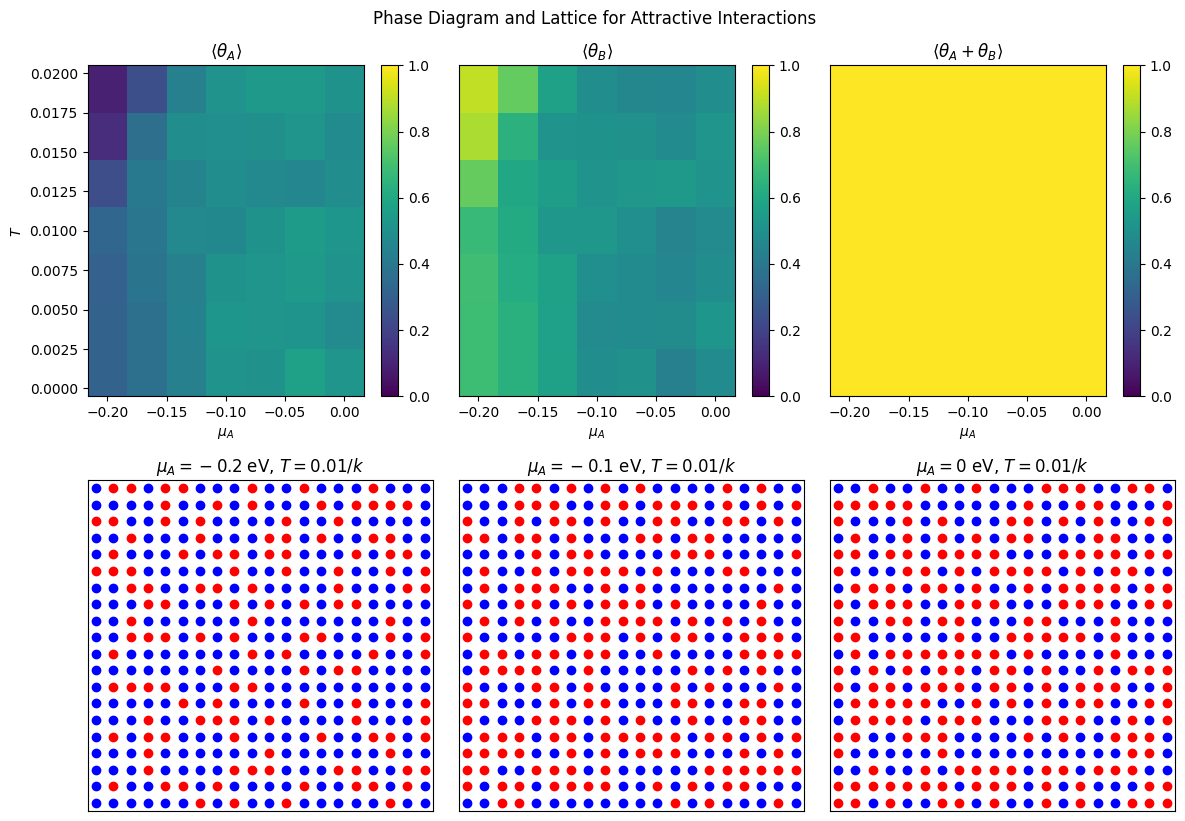

Running simulation for Immiscible...


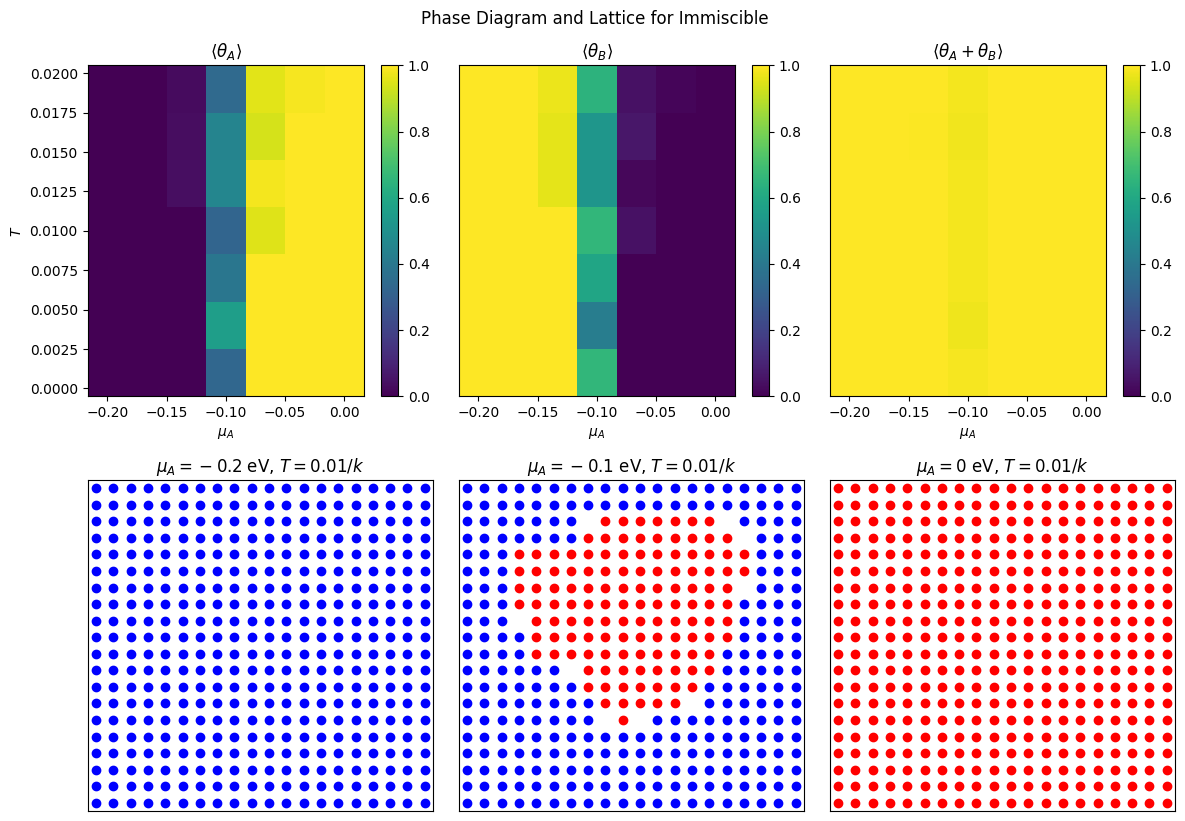

Running simulation for Like Dissolves Unlike...


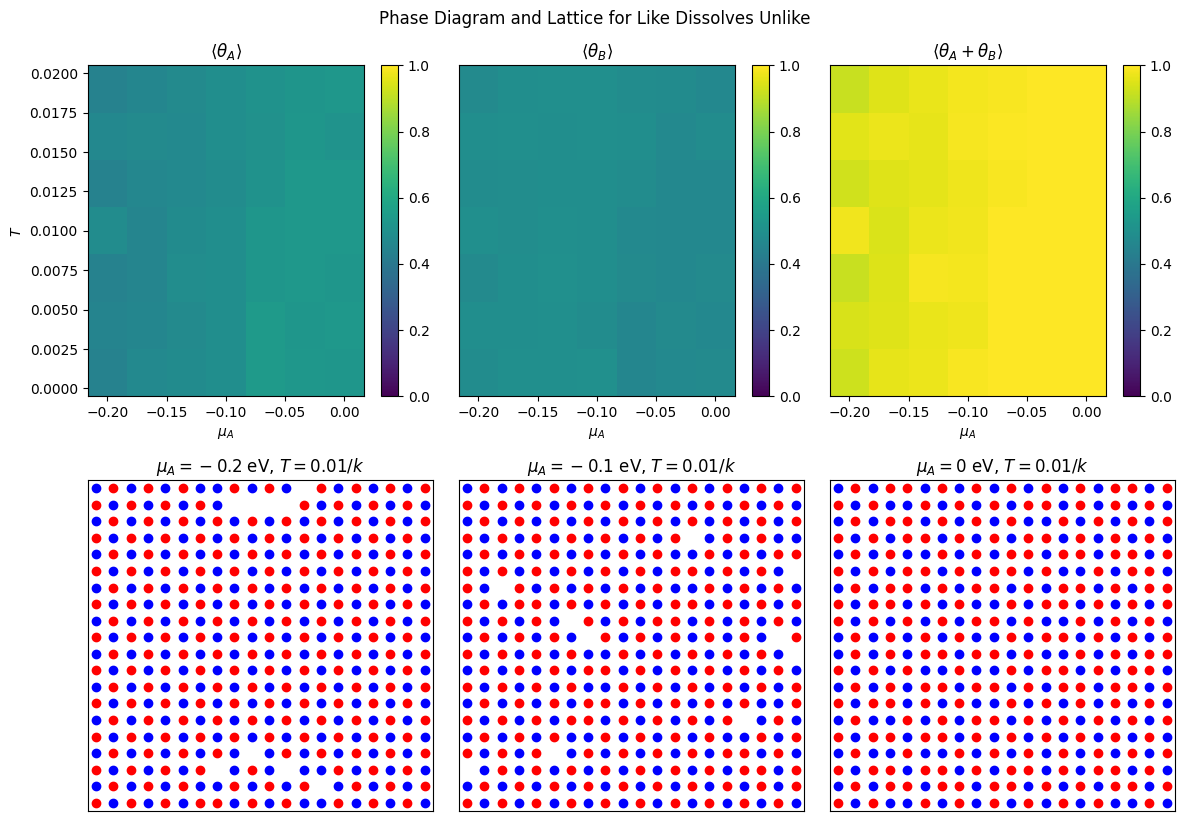

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Constants
lattice_size = 20  # Lattice size (NxN)
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7)
Ts = np.linspace(0.001, 0.019, 7)

# Interaction parameters (eV)
interaction_sets = {
    "Ideal Mixture": [-0.1, -0.1, 0.0, 0.0, 0.0],
    "Repulsive Interactions": [-0.1, -0.1, 0.05, 0.05, 0.05],
    "Attractive Interactions": [-0.1, -0.1, -0.05, -0.05, -0.05],
    "Immiscible": [-0.1, -0.1, -0.05, -0.05, 0.05],
    "Like Dissolves Unlike": [-0.1, -0.1, 0.05, 0.05, -0.05]
}

# Function to initialize lattice
def initialize_lattice(size):
    return np.zeros((size, size))

# Function to compute neighbor indices
def compute_neighbor_indices(size):
    neighbor_indices = {}
    for x in range(size):
        for y in range(size):
            neighbors = [
                ((x - 1) % size, y),
                ((x + 1) % size, y),
                (x, (y - 1) % size),
                (x, (y + 1) % size)
            ]
            neighbor_indices[(x, y)] = neighbors
    return neighbor_indices

# Function to calculate interaction energy
def calculate_interaction_energy(lattice, site, particle, neighbor_indices, epsilon_AA, epsilon_BB, epsilon_AB):
    x, y = site
    interaction_energy = 0
    for neighbor in neighbor_indices[(x, y)]:
        neighbor_particle = lattice[neighbor]
        if neighbor_particle != 0:
            if particle == 1:  # Particle A
                if neighbor_particle == 1:
                    interaction_energy += epsilon_AA
                else:  # Neighbor is Particle B
                    interaction_energy += epsilon_AB
            else:  # Particle B
                if neighbor_particle == 2:
                    interaction_energy += epsilon_BB
                else:  # Neighbor is Particle A
                    interaction_energy += epsilon_AB
    return interaction_energy

# Function to attempt a Monte Carlo move
def attempt_move(lattice, N_A, N_B, N_empty, neighbor_indices, params):
    size = lattice.shape[0]
    N_sites = size * size
    beta = 1 / params['T']
    epsilon_A, epsilon_B, epsilon_AA, epsilon_BB, epsilon_AB, mu_A, mu_B = (
        params['epsilon_A'], params['epsilon_B'], params['epsilon_AA'],
        params['epsilon_BB'], params['epsilon_AB'], params['mu_A'], params['mu_B']
    )

    if random.random() < 0.5:  # Attempt to add a particle
        if N_empty == 0:
            return N_A, N_B, N_empty  # No empty sites available
        site = random.choice(np.argwhere(lattice == 0))
        particle = random.choice([1, 2])
        mu = mu_A if particle == 1 else mu_B
        epsilon = epsilon_A if particle == 1 else epsilon_B
        N_s = N_A if particle == 1 else N_B
        delta_E = epsilon + calculate_interaction_energy(lattice, tuple(site), particle, neighbor_indices, epsilon_AA, epsilon_BB, epsilon_AB)
        acc_prob = min(1, (N_empty / (N_s + 1)) * np.exp(-beta * (delta_E - mu)))
        if random.random() < acc_prob:
            lattice[tuple(site)] = particle
            if particle == 1:
                N_A += 1
            else:
                N_B += 1
            N_empty -= 1
    else:  # Attempt to remove a particle
        if N_sites - N_empty == 0:
            return N_A, N_B, N_empty  # No particles to remove
        site = random.choice(np.argwhere(lattice != 0))
        particle = lattice[tuple(site)]
        mu = mu_A if particle == 1 else mu_B
        epsilon = epsilon_A if particle == 1 else epsilon_B
        N_s = N_A if particle == 1 else N_B
        delta_E = -epsilon - calculate_interaction_energy(lattice, tuple(site), particle, neighbor_indices, epsilon_AA, epsilon_BB, epsilon_AB)
        acc_prob = min(1, (N_s / (N_empty + 1)) * np.exp(-beta * (delta_E + mu)))
        if random.random() < acc_prob:
            lattice[tuple(site)] = 0
            if particle == 1:
                N_A -= 1
            else:
                N_B -= 1
            N_empty += 1
    return N_A, N_B, N_empty

# Function to run the simulation
def run_simulation(size, n_steps, params):
    lattice = initialize_lattice(size)
    neighbor_indices = compute_neighbor_indices(size)
    N_sites = size * size
    N_A, N_B, N_empty = 0, 0, N_sites
    coverage_A = np.zeros(n_steps)
    coverage_B = np.zeros(n_steps)

    for step in range(n_steps):
        N_A, N_B, N_empty = attempt_move(lattice, N_A, N_B, N_empty, neighbor_indices, params)
        coverage_A[step] = N_A / N_sites
        coverage_B[step] = N_B / N_sites

    return lattice, coverage_A, coverage_B

# Function to plot the lattice
def plot_lattice(lattice, ax, title):
    size = lattice.shape[0]
    for x in range(size):
        for y in range(size):
            if lattice[x, y] == 1:
                ax.plot(x + 0.5, y + 0.5, 'ro')  # Red for Particle A
            elif lattice[x, y] == 2:
                ax.plot(x + 0.5, y + 0.5, 'bo')  # Blue for Particle B
    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(which='minor')
    ax.set_title(title)
    return ax

# Running simulation for each interaction set
for interaction_name, interaction_params in interaction_sets.items():
    print(f"Running simulation for {interaction_name}...")
    params_list = []
    for mu_A in mus_A:
        for T in Ts:
            params_list.append({
                'epsilon_A': interaction_params[0],
                'epsilon_B': interaction_params[1],
                'epsilon_AA': interaction_params[2],
                'epsilon_BB': interaction_params[3],
                'epsilon_AB': interaction_params[4],
                'mu_A': mu_A,
                'mu_B': -0.1,
                'T': T
            })

    # Run the simulation
    np.random.seed(42)
    final_lattice = np.zeros((len(mus_A), len(Ts), lattice_size, lattice_size))
    mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
    mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
    for i, param in enumerate(params_list):
        lattice, coverage_A, coverage_B = run_simulation(lattice_size, n_steps, param)
        final_lattice[i // len(Ts), i % len(Ts)] = lattice
        mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
        mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

    # Plot the T-mu_A phase diagram
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    axs = axs.ravel()

    # Mean coverage of A
    cax1 = axs[0].pcolormesh(mus_A, Ts, mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
    axs[0].set_title(r'$\langle \theta_A \rangle$')
    axs[0].set_xlabel(r'$\mu_A$')
    axs[0].set_ylabel(r'$T$')
    fig.colorbar(cax1, ax=axs[0])

    # Mean coverage of B
    cax2 = axs[1].pcolormesh(mus_A, Ts, mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
    axs[1].set_title(r'$\langle \theta_B \rangle$')
    axs[1].set_xlabel(r'$\mu_A$')
    axs[1].set_yticks([])
    fig.colorbar(cax2, ax=axs[1])

    # Mean total coverage
    cax3 = axs[2].pcolormesh(mus_A, Ts, mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
    axs[2].set_title(r'$\langle \theta_A + \theta_B \rangle$')
    axs[2].set_xlabel(r'$\mu_A$')
    axs[2].set_yticks([])
    fig.colorbar(cax3, ax=axs[2])

    # Plot the final lattice configuration
    plot_lattice(final_lattice[0, 3], axs[3], r'$\mu_A = -0.2$ eV, $T = 0.01 / k$')
    plot_lattice(final_lattice[3, 3], axs[4], r'$\mu_A = -0.1$ eV, $T = 0.01 / k$')
    plot_lattice(final_lattice[6, 3], axs[5], r'$\mu_A = 0$ eV, $T = 0.01 / k$')

    plt.tight_layout()
    plt.suptitle(f"Phase Diagram and Lattice for {interaction_name}", y=1.02)
    plt.show()
